In [9]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using Plots
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
     

In [10]:
gamma::Float64 = 0
gamma_3::Float64 = 10
c::Float64 = 1
omega::Float64 = 10

@parameters x,t
@variables A(..), B(..)
r1 = @rule cos(~x)^3 => 0.75 * cos(~x) + 0.25 * cos(3 * ~x)
r2 = @rule sin(~x)^3 => 0.75 * sin(~x) - 0.25 * sin(3 * ~x)
r3 = @rule cos(~x)^2 => 1 - sin(~x)^2
r4 = @rule sin(~x)^2 => 1 - cos(~x)^2


xleft::Float64 = 0.0
xright::Float64 = 1.0
N = 200
order = 2
stepx = (xright-xleft)/N
u = A(x) * sin(omega*t) + B(x) * cos(omega*t)
Dx = Differential(x)
Dt = Differential(t)
y = Dt(Dt(u)) - c*c*Dx(Dx(u)) + gamma*Dt(u) + gamma_3*Dt(u)*Dt(u)*Dt(u)
y_exp = expand_derivatives(y)

y_exp = simplify(expand(y_exp), RuleSet([r1, r2, r3, r4]))
y_exp = expand(y_exp)
y_exp = simplify(y_exp, RuleSet([r1, r2, r3, r4]))

sin_coeff = -Symbolics.coeff(y_exp, sin(omega*t))
cos_coeff = -Symbolics.coeff(y_exp, cos(omega*t))

#=sin_sol = Symbolics.solve_for(sin_coeff ~ 0, Differential(x)(Differential(x)(A(x))))
println("Sin:")
println("Sin coeff: ", sin_coeff)
println("Axx = ", sin_sol)

fA = Symbolics.build_function(sin_sol, A(x), B(x), gamma, omega, c; expression=Val{false})

cos_sol = Symbolics.solve_for(cos_coeff ~ 0, Differential(x)(Differential(x)(B(x))))
println("Cos:")
println("Cos coeff: ", cos_coeff)
println("Bxx = ", cos_sol)

fB = Symbolics.build_function(cos_sol, A(x), B(x), gamma, omega, c; expression=Val{false})=#
     


100.0B(x) + Differential(x)(Differential(x)(B(x))) - 7500.0(A(x)^3) - 7500.0A(x)*(B(x)^2)

In [11]:
function transform_sym(expr_str)
    corrected = string(expr_str)

    repl_lapl = [
        "Differential(x)(Differential(x)(A(x)))" => "(A[i+1] - 2A[i] + A[i-1]) / dx^2",
        "Differential(x)(Differential(x)(B(x)))" => "(B[i+1] - 2B[i] + B[i-1]) / dx^2",
        ]
    repl_first_der = [
        "Differential(x)(A(x))" => "(A[i+1] - A[i-1]) / (2*dx)",
        "Differential(x)(B(x))" => "(B[i+1] - B[i-1]) / (2*dx)",
        ]
    repl_linear = [
        "A(x)" => "A[i]",
        "B(x)" => "B[i]"
        ]

    corrected = replace(corrected, repl_lapl...)
    corrected = replace(corrected, repl_first_der...)
    corrected = replace(corrected, repl_linear...)

    repl_powers = [
        "A[i]^" => "(A[i])^",
        "B[i]^" => "(B[i])^"
        ]
    repl_mult_pattern = r"(?<=\d)(?=[A-Za-z\(])"

    corrected = replace(corrected, repl_powers...)
    corrected = replace(corrected, repl_mult_pattern => "*")

    #Finar corrections (required for scope):
    repl_sym = [
        "A" => "A_array",
        "B" => "B_array",
        "i" => "i_local",
        ]

    corrected = replace(corrected, repl_sym...)

    return corrected
end

transform_sym (generic function with 1 method)

In [12]:
println("Trial substitution:")
println(transform_sym(sin_coeff))

Trial substitution:
100.0*A_array[i_local] + (A_array[i_local+1] - 2*A_array[i_local] + A_array[i_local-1]) / dx^2 + 7500.0*((A_array[i_local])^2)*B_array[i_local] + 7500.0*((B_array[i_local])^3)


In [13]:
function create_residual_function_1D(N, sin_eq_str, cos_expr_str)
    function_code = """
    function residual!(F, U, p)
        dx = p

        A_array = @view(U[1:$N+1])
        B_array = @view(U[$N+2:end])
        F_A = @view(F[1:$N+1])
        F_B = @view(F[$N+2:end])

        # Inner points:
        for i_local in 2:$(N)
            F_A[i_local] = ($sin_eq_str) - 1000
            F_B[i_local] = ($cos_expr_str) 
        end

        # Dirichlet BCs
        F_A[1] = A_array[1]
        F_A[end] = A_array[end]
        F_B[1] = B_array[1]
        F_B[end] = B_array[end]

        return F
    end
    """
    return eval(Meta.parse(function_code))
end


create_residual_function_1D (generic function with 1 method)

In [14]:
sin_eq_str = transform_sym(sin_coeff)
cos_eq_str = transform_sym(cos_coeff)

nonlinear_residual = create_residual_function_1D(N, sin_eq_str, cos_eq_str)
initial_guess = ones(2*(N+1))

prob = NonlinearProblem(nonlinear_residual, initial_guess, stepx)
sol = NonlinearSolve.solve(prob, NewtonRaphson(), reltol = 1e-5, abstol = 1e-5)

retcode: Success
u: 402-element Vector{Float64}:
 -2.277377630255715e-19
 -0.09219298361343325
 -0.15934611940197674
 -0.2023822869071564
 -0.22350435962125892
 -0.22604985250004106
 -0.2140749274390716
 -0.19185005078379794
 -0.16340772129007647
 -0.1322207126980046
 -0.10103119054872993
 -0.07181181934085624
 -0.0458217796299033
  ⋮
  0.5298864528439468
  0.5191123311049375
  0.5017422598225553
  0.4764433078735777
  0.4421801371455254
  0.3984541783714437
  0.3455198833359186
  0.2844959980111621
  0.2172755656279439
  0.1461662895793079
  0.07329465708691954
  0.0

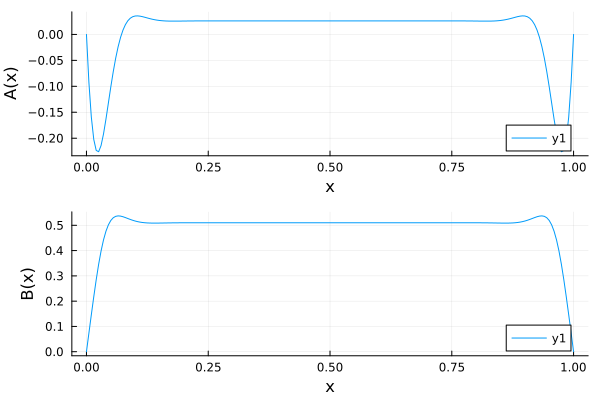

In [15]:
xgrid = collect(range(start=0.0, stop=1.0, step=stepx))
myA  = sol.u[1:N+1]
myB  = sol.u[N+2:end]
p1 = plot(xgrid, myA, xlabel="x", ylabel = "A(x)")
p2 = plot(xgrid, myB, xlabel="x", ylabel = "B(x)")
plot(p1,p2,layout=(2,1))

[ Info: Saved animation to /home/kamilj/Documents/git_repos/TW3715TU-2025-ShallowWaters/HB.gif


Plots.AnimatedGif("/home/kamilj/Documents/git_repos/TW3715TU-2025-ShallowWaters/HB.gif")
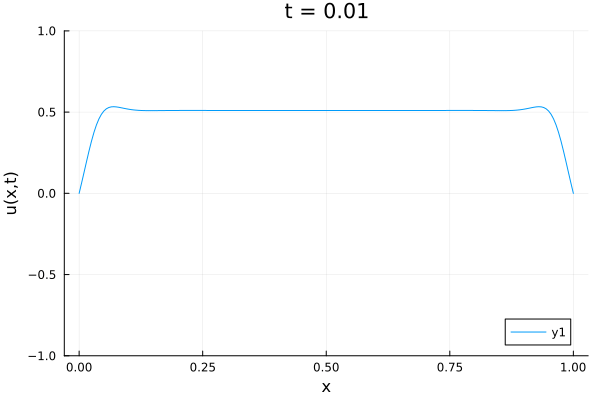

In [17]:
Nt = 5
dt = 0.01

animation = @animate for k in 1:(Nt/dt)
    new_u = myA * sin(omega * (k * dt)) .+ myB * cos(omega * (k * dt))
    plot(xgrid, new_u,
         title="t = $(k * dt)", xlabel="x", ylabel="u(x,t)", ylim = (-1, 1))
end

gif(animation, "HB.gif", fps = 60)